# EGAT Implementation

```
Rossmann-toolbox: a deep learning-based protocol for the prediction and design of cofactor specificity in Rossmann fold proteins
```

In [1]:
import dgl
from dgl.data import DGLDataset
import torch
import os
import pandas as pd
import numpy as np
import torch
import itertools
import numpy as np
import scipy.sparse as sp
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
from dgl.nn import EGATConv
from utils.startup_data_set import *
from utils.PredictorClasses import *
from utils.CustomMetrics import *
from utils.CustomUtilities import *
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Dataset

In [2]:
graph = COMP4222Dataset()
g = graph[0].to(device)

## Generate Postitve Graph and Negative Graph with Spliting

In [3]:
train_g, train_pos_g, val_pos_g, test_pos_g, val_g, test_g = generate_pos_graph(g)

In [4]:
train_neg_g, val_neg_g, test_neg_g = generate_neg_graph(g)

In [5]:
train_g, train_pos_g, val_pos_g, test_pos_g = train_g.to(device), train_pos_g.to(device), val_pos_g, test_pos_g.to(device)
train_neg_g, val_neg_g, test_neg_g = train_neg_g.to(device), val_neg_g.to(device), test_neg_g.to(device)
num_nodes = g.num_nodes
num_edges = g.num_edges

## Model Training

### Model Setup

In [6]:
class EGAT_Model(nn.Module):
    def __init__(self, in_node_feats,in_edge_feats, hid_node_feats,hid_edge_feats, out_node_feats,out_edge_feats, heads):
        super(EGAT_Model, self).__init__()

        self.layers = nn.ModuleList()
        # input layer
        self.layers.append(EGATConv(in_node_feats = in_node_feats,
                                        in_edge_feats = in_edge_feats,
                                        out_node_feats = hid_node_feats,
                                        out_edge_feats = hid_edge_feats,
                                        num_heads = heads[0]).to(device))
        # hidden layers
        self.layers.append(EGATConv(in_node_feats = hid_node_feats * heads[0],
                                    in_edge_feats =  hid_edge_feats * heads[0],
                                    out_node_feats = hid_node_feats,
                                    out_edge_feats = hid_edge_feats,
                                    num_heads = heads[1]).to(device))
        # output layer
        self.layers.append(EGATConv(in_node_feats = hid_node_feats * heads[1],
                                        in_edge_feats =  hid_edge_feats * heads[1],
                                        out_node_feats = out_node_feats,
                                        out_edge_feats = out_edge_feats,
                                        num_heads = heads[2]).to(device))
        
    def forward(self, g, n_features, e_features):
        nh = n_features.float()
        eh = e_features.float()
        for i, layer in enumerate(self.layers):
            nh,eh = layer(g, nh, eh)
            if i == 2:  # last layer 
                nh = nh.mean(1)
                eh = eh.mean(1)
            else:       # other layer(s)
                nh = nh.flatten(1)
                eh = eh.flatten(1)
        return nh, eh

## Hyperparameters

In [7]:
in_node_feats = train_g.ndata["feat"].shape[1]
in_edge_feats = train_g.edata["feat"].shape[1] 
hid_node_feats = 64
hid_edge_feats = 64
out_node_feats = 16
out_edge_feats = train_g.edata["feat"].shape[1] 
heads = [2,2,2]

In [11]:
egat_model = EGAT_Model(in_node_feats = in_node_feats,
                      in_edge_feats = in_edge_feats, 
                      hid_node_feats = hid_node_feats,
                      hid_edge_feats = hid_edge_feats, 
                      out_node_feats = out_node_feats,
                      out_edge_feats = out_edge_feats,
                      heads = heads).to(device).to(device)

class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(2*h_feats , h_feats).to(torch.float32)
        self.W2 = nn.Linear(h_feats, 1).to(torch.float32)

    # concat the source and destination node, use mlp to predict the score
    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1).to(torch.float32)

        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h.to(torch.float32)
            g.apply_edges(self.apply_edges)
            return g.edata['score']


pred = MLPPredictor(16).to(device)
early_stopping = 10


### Training Loop

In [12]:
import itertools

train_loss, val_loss = [], []
train_AUC, val_AUC = [], []
stop = 0
ep = 100
optimizer = torch.optim.Adam(itertools.chain(egat_model.parameters(), pred.parameters()))

for e in range(ep):
    # forward
    h, efeat= egat_model(train_g, train_g.ndata['feat'].to(torch.float32), train_g.edata["feat"].to(torch.float32))
    pos_score = pred(train_pos_g.to(device),h.to(device))
    neg_score = pred(train_neg_g.to(device),h.to(device))
    # update 
    
    loss = compute_loss(pos_score, neg_score)
    train_loss.append(loss.item())
    train_AUC.append(compute_auc(pos_score, neg_score))

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # validation
    v_pos_score = pred(val_pos_g, h)
    v_neg_score = pred(val_neg_g, h)
    v_loss = compute_loss(v_pos_score, v_neg_score)
    val_loss.append(v_loss.item())
    val_AUC.append(compute_auc(v_pos_score, v_neg_score))

    #verbose
    if e % 10 == 0:
        print('Epoch: {} \t Train loss: {} \t Val loss: {} \t Train AUC: {} \t Val AUC: {}'.format(e, round(loss.item(), 3), round(v_loss.item(), 3), round(train_AUC[-1],3), round(val_AUC[-1], 3)))


    # early stopping
    if e > 10:
        if v_loss.item() > sum(val_loss[-5:])/5:
            stop += 1
        else: 
            stop = 0
        if stop >= early_stopping:
            print("Early Stopped at Epoch {}".format(e))
            break

Epoch: 0 	 Train loss: 0.693 	 Val loss: 0.693 	 Train AUC: 0.522 	 Val AUC: 0.529
Epoch: 10 	 Train loss: 0.668 	 Val loss: 0.672 	 Train AUC: 0.731 	 Val AUC: 0.698
Epoch: 20 	 Train loss: 0.596 	 Val loss: 0.608 	 Train AUC: 0.835 	 Val AUC: 0.794
Epoch: 30 	 Train loss: 0.483 	 Val loss: 0.516 	 Train AUC: 0.871 	 Val AUC: 0.835
Epoch: 40 	 Train loss: 0.402 	 Val loss: 0.456 	 Train AUC: 0.895 	 Val AUC: 0.861
Epoch: 50 	 Train loss: 0.332 	 Val loss: 0.4 	 Train AUC: 0.939 	 Val AUC: 0.898
Epoch: 60 	 Train loss: 0.28 	 Val loss: 0.372 	 Train AUC: 0.952 	 Val AUC: 0.916
Epoch: 70 	 Train loss: 0.253 	 Val loss: 0.372 	 Train AUC: 0.958 	 Val AUC: 0.923
Epoch: 80 	 Train loss: 0.231 	 Val loss: 0.374 	 Train AUC: 0.964 	 Val AUC: 0.925
Early Stopped at Epoch 87


In [13]:
# testing AUC
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC:', compute_auc(pos_score, neg_score))

AUC: 0.9257991266895906


### Result Plotting

Text(0, 0.5, 'Loss')

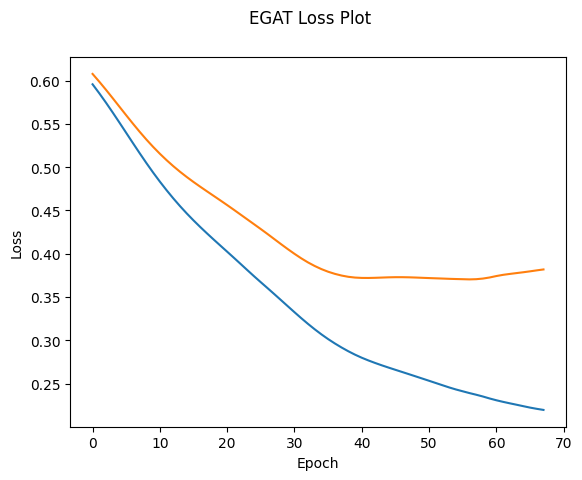

In [14]:
fig = plt.figure()
plt.plot(train_loss[20:], label='training loss')
plt.plot(val_loss[20:], label = 'validation loss')
fig.suptitle('EGAT Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'AUC')

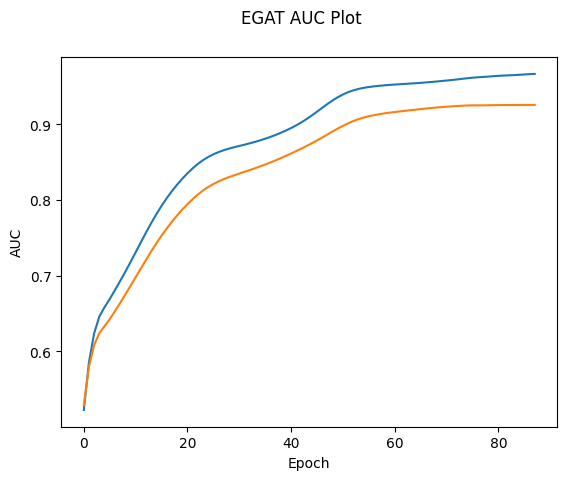

In [15]:
fig = plt.figure()
plt.plot(train_AUC, label='training AUC')
plt.plot(val_AUC, label = 'validation AUC')
fig.suptitle('EGAT AUC Plot')
plt.xlabel('Epoch')
plt.ylabel('AUC')